In [34]:
import pandas as pd
import numpy as np
import torch 
import wandb
import os
from torch import nn
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score
import GLC23_Dataset_code
from GLC23_Dataset_code import GLC23Datasets , GLC23PatchesProviders , GLC23TimeSeriesProviders
from GLC23_Dataset_code.GLC23Datasets import RGBNIR_env_Dataset
## from models import MLP
from util import seed_everything
import matplotlib.pyplot as plt
from PIL import Image





In [2]:
df = pd.read_csv('data/sample_data/Presence_only_occurrences/Presences_only_train_sample.csv', sep=';')
df

,glcID,gbifID,observer,datasetName,date,dayOfYear,year,year_ecodatacube_quarter,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM,speciesId,patchID,timeSerieID
0,2522017,1.882957e+09,Bjørn Petter Løfall,NOR Species Observation,2018-06-17,168,2018,2.0,10.951540,59.25110,4375406.0,4017067.0,10.00,9343,5982155,2959445
1,915820,3.704105e+09,"Szokala,Daniel",Masaryk Univ Herbarium,2020-08-23,236,2020,3.0,22.678360,43.39697,5345300.0,2341095.0,10.00,2165,6920543,3900275
2,2204483,2.634620e+09,Mykyta Peregrym,iNaturalist RG,2020-06-01,153,2020,2.0,20.057780,47.91972,5070487.0,2807349.0,5.00,7722,6876987,3856654
3,1892353,2.894783e+09,Vejle Kommune,DEN Environmental Portal,2018-05-16,136,2018,2.0,9.337563,55.75870,4279387.0,3628455.0,3.00,6461,5547194,2523020
4,3377718,1.884870e+09,Bernt-Gunnar Østerkløft,NOR Species Observation,2018-07-18,199,2018,3.0,14.614180,67.38264,4520783.0,4924950.0,50.00,7287,6592021,3570234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4510301,2.823071e+09,Kamil Konowalik,iNaturalist RG,2020-07-18,200,2020,3.0,17.369410,51.13202,4835844.0,3139412.0,48.00,8504,6808612,3788047
96,2873774,2.985083e+09,Kamilla Svingen,NOR Species Observation,2020-11-22,327,2020,4.0,9.546747,59.13283,4294996.0,4003638.0,5.00,4318,5598953,2574870
97,3019471,2.847813e+09,Jukka Väyrynen,ArtPortalen,2020-08-01,214,2020,3.0,16.439410,56.43098,4717999.0,3720884.0,25.00,3911,6749721,3729009
98,3849105,2.975628e+09,NaN,Pl@ntNet automatic,2020-07-14,196,2020,3.0,9.702714,50.86739,4300071.0,3084033.0,12.00,9669,5641177,2617157


## SET SEEDS

In [3]:
seed_everything(42)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Import sample of the data

    Set Path of data folder

In [5]:
data_path = "data/sample_data/"
presence_only_path = data_path + "Presence_only_occurrences/Presences_only_train_sample.csv"
presence_absence_path = data_path + "Presence_Absences_occurrences/Presences_Absences_train_sample.csv"

## Set Hyperparameters 

In [6]:
BATCH_SIZE = 2
LEARNING_RATE=1e-3
N_EPOCHS = 10
BIN_TRESH = 0.1
NUM_WORKERS = os.cpu_count()
print(NUM_WORKERS)


8


## Set name of the run

In [7]:
run_name = 'First_run_100_samples'
if not os.path.exists(f"models/{run_name}"): 
    os.makedirs(f"models/{run_name}")

## Create Train and Validation Set

In [8]:
## TRAIN Set


presence_only_df = pd.read_csv(presence_only_path, sep=";", header='infer', low_memory=False)


train_dataset = RGBNIR_env_Dataset(presence_only_df, env_patch_size=10, rgbnir_patch_size=100)
n_species = len(train_dataset.species)
print(f"Training set: {len(train_dataset)} sites, {n_species} sites")

Training set: 100 sites, 96 sites


In [9]:
print(f"5 first element of the train_dataset : /n  {train_dataset.occurrences.head(5)}")

5 first element of the train_dataset : /n       glcID        gbifID                 observer               datasetName  \
0  2522017  1.882957e+09      Bjørn Petter Løfall   NOR Species Observation   
1   915820  3.704105e+09           Szokala,Daniel    Masaryk Univ Herbarium   
2  2204483  2.634620e+09          Mykyta Peregrym            iNaturalist RG   
3  1892353  2.894783e+09            Vejle Kommune  DEN Environmental Portal   
4  3377718  1.884870e+09  Bernt-Gunnar Østerkløft   NOR Species Observation   

         date  dayOfYear  year  year_ecodatacube_quarter        lon       lat  \
0  2018-06-17        168  2018                       2.0  10.951540  59.25110   
1  2020-08-23        236  2020                       3.0  22.678360  43.39697   
2  2020-06-01        153  2020                       2.0  20.057780  47.91972   
3  2018-05-16        136  2018                       2.0   9.337563  55.75870   
4  2018-07-18        199  2018                       3.0  14.614180  67.38264

In [10]:
presence_absence_df = pd.read_csv(presence_absence_path, sep=";", header='infer', low_memory=False)
val_dataset = RGBNIR_env_Dataset(presence_absence_df, species=train_dataset.species, env_patch_size=10, rgbnir_patch_size=100)
print(f"Validation set: {len(val_dataset)} sites, {len(val_dataset.species)} sites")


Validation set: 99 sites, 96 sites


In [11]:
dropped_NA

NameError: name 'dropped_NA' is not defined

In [12]:
print(f" number of element in the train dataset : {len(train_dataset.occurrences)}")
print(f"first element of the train_dataset :\n  {train_dataset.occurrences.head(1)}")
print(f" number of element in the train dataset : {len(val_dataset.occurrences)}")
print(f" first element of the val_dataset : \n  {val_dataset.occurrences.head(1)}")

 number of element in the train dataset : 100
first element of the train_dataset :
       glcID        gbifID             observer              datasetName  \
0  2522017  1.882957e+09  Bjørn Petter Løfall  NOR Species Observation   

         date  dayOfYear  year  year_ecodatacube_quarter       lon      lat  \
0  2018-06-17        168  2018                       2.0  10.95154  59.2511   

   x_EPSG3035  y_EPSG3035  geoUncertaintyInM  speciesId  patchID  timeSerieID  
0   4375406.0   4017067.0               10.0       9343  5982155      2959445  
 number of element in the train dataset : 100
 first element of the val_dataset : 
     Unnamed: 0    glcID  gbifID observer datasetName        date  dayOfYear  \
0       74594  5688737     NaN      NaN      CBNMed  1587938400        118   

   year      lon      lat  x_EPSG3035  y_EPSG3035  geoUncertaintyInM  \
0  2020  6.48976  43.1676   4034867.0   2235568.0               10.0   

   speciesId  patchID  timeSerieID  
0       1275   116777  

In [26]:
len(train_dataset)

100

## Dataloader

In [52]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=2, num_workers=1) ## Maybe use a transform argument 
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [53]:
print(f"Dataloaders: {train_loader, val_loader}") 
print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(val_loader)} batches of {BATCH_SIZE}")



Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x2ac889b90>, <torch.utils.data.dataloader.DataLoader object at 0x2ae27cb90>)
Length of train dataloader: 50 batches of 2
Length of test dataloader: 50 batches of 2


Here is the shape of the element in the data loader : 
Rgb element: torch.Size([4, 100, 100])
Environment element: torch.Size([4, 10, 10])
Label: torch.Size([96]) 
<class 'torch.Tensor'>
<built-in method mode of Tensor object at 0x179aacd10>
<built-in method size of Tensor object at 0x179aacd10>


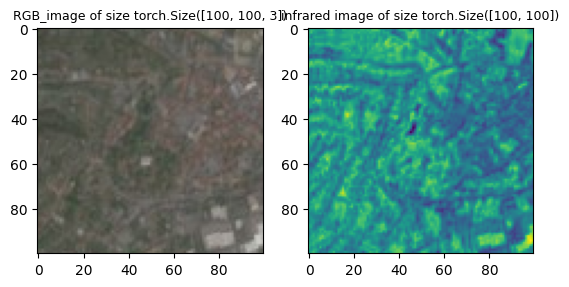

In [65]:
rgb , env ,train_label = next(iter(train_loader))

first_rgb , first_env ,first_train = rgb[1] , env[1] , train_label[1]

print("Here is the shape of the element in the data loader : ")
print(f"Rgb element: {first_rgb.shape}") 
print(f"Environment element: {first_env.shape}")
print(f"Label: {first_train.shape} ")

#rgb_array = np.transpose((first_rgb[:3]*255).astype(np.uint8), (1, 2, 0))

image_rgb = first_rgb[:3].permute(1, 2, 0)
image_nir = first_rgb[3]
print(f" type of infrared : {type(image_nir)} ")
fig, ax = plt.subplots(1, 2)

ax[0].imshow(image_rgb)
ax[0].set_title(f"RGB_image of size {image_rgb.shape}",fontsize = 9)
ax[1].imshow(image_nir)
ax[1].set_title(f"infrared image of size {image_nir.shape}" , fontsize = 9)
print(type(image_nir))
# summarize image details
print(image_nir.mode)
print(image_nir.size)
#nir_array = np.transpose(first_rgb[3], (1, 2, 0))

#nir_array = np.transpose(first_rgb[3], (1, 2, 0))





In [ ]:
bio_1 , bio_2 , bio_3 , bio_4  = first_env[0] , first_env[1] , first_env[2] , first_env[3]


figure, axe = plt.subplots(2, 2)


axe[0][0].imshow(bio_1.numpy())
axe[0][1].imshow(bio_2.numpy())
axe[1][0].imshow(bio_3.numpy())
axe[1][1].imshow(bio_4.numpy())

In [ ]:

    class twoBranchCNN(nn.Module):

        def __init__(self, n_species):
            super().__init__()
            self.conv1 = nn.Conv2d(4, 8, kernel_size=5)
            self.batchnorm1 = nn.BatchNorm2d(8)
            self.act1 = nn.ReLU()
            self.pool1 = nn.MaxPool2d(kernel_size=2)

            self.conv2 = nn.Conv2d(8, 8, kernel_size=5)
            self.batchnorm2 = nn.BatchNorm2d(8)
            self.act2 = nn.ReLU()
            self.pool2 = nn.MaxPool2d(kernel_size=4)
            self.flat2 = nn.Flatten()

            self.conv3 = nn.Conv2d(4, 1, kernel_size=3)
            self.batchnorm3 = nn.BatchNorm2d(1)
            self.act3 = nn.ReLU()

            self.conv4 = nn.Conv2d(1, 1, kernel_size=3)
            self.batchnorm4 = nn.BatchNorm2d(1)
            self.act4 = nn.ReLU()
            self.flat4 = nn.Flatten()

            self.fc5 = nn.Linear(1004, 1024)
            self.act5 = nn.ReLU()

            self.fc6 = nn.Linear(1024, n_species)

        def forward(self, rgb_x, env_x, val=False):
            if val: print(rgb_x.shape)
            # input 4x100x100 -> output 4x96x96 (k=5)
            print(self.conv1(rgb_x).shape)
            rgb_x = self.act1(self.batchnorm1(self.conv1(rgb_x)))
            # input 8x96x96 -> output 8x48x48 (k=2)
            rgb_x = self.pool1(rgb_x)
            # input 8x48x48 -> output 8x44x44 (k=5)
            rgb_x = self.act2(self.batchnorm2(self.conv2(rgb_x)))
            # input 8x44x44 -> output 8x11x11 (k=4)
            rgb_x = self.pool2(rgb_x)
            # input 8x11x11 -> output 968
            rgb_x = self.flat2(rgb_x)
            if val: print(rgb_x.shape)

            if val: print(env_x.shape)
            # input 21x10x10 -> output 16x8x8 (k=3)
            print(self.conv3(env_x).shape)
            env_x = self.act3(self.batchnorm3(self.conv3(env_x)))
            # input 16x8x8 -> output 16x6x6 (k=3)
            env_x = self.act4(self.batchnorm4(self.conv4(env_x)))
            # inpput 16x6x6 -> output 576 (k=2)
            env_x = self.flat4(env_x)
            if val: print(env_x.shape)

            #if val: print(x.shape)
            # 968 + 576 = 1544
            x = torch.cat((rgb_x, env_x), dim=1)
            if val: print(x.shape)
            # input 1544 -> output 1024
            x = self.act5(self.fc5(x))
            # input 1024 -> output n_species
            x = self.fc6(x)
            return x

In [ ]:
model = twoBranchCNN(n_species).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)#, momentum=0.9)

loss_fn = torch.nn.BCEWithLogitsLoss() 

## Test with a single image

In [ ]:
gb_test ,env_test , label_test = next(iter(train_loader))

single_rgb ,single_env ,single_label = rgb_test[0].unsqueeze(0) , env_test[0].unsqueeze(0), label_test[0]



print(f"Single sample rgb shape {single_rgb.shape}")
print(f"Single sample env shape {single_env.shape}")

model.eval()


y_pred = []
y_loss = []
with torch.inference_mode():
    print(single_rgb.to(torch.float32).to(device).shape)
    y_pred = model(single_rgb.to(torch.float32).to(device), single_env.to(torch.float32).to(device),True)
    print(torch.argmax(torch.softmax(y_pred, dim=1), dim=1))
    y_loss = loss_fn(y_pred,single_label.to(torch.float32).to(device).unsqueeze(0))
    print(y_loss)

print("Output logits : {y_pred}")
#print(f"Output prediction probability :\n { torch.softmax(y_pred, dim= 1)}")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(y_pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{single_label}")

## Not working

In [ ]:
for epoch in range(0, N_EPOCHS):
        print(f"EPOCH {epoch}")

        model.train()
        train_loss_list = []
        for rgb, env, labels in tqdm(train_loader):
            y_pred = model(rgb.to(torch.float32).to(device), env.to(torch.float32).to(device))
            loss = loss_fn(y_pred, labels.to(torch.float32).to(device))
### Training the model and evaluating it 

## Import Models



In [39]:
model = twoBranchCNN(n_species).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)#, momentum=0.9)
loss_fn = torch.nn.BCEWithLogitsLoss() 



## Set-Up wandb

In [40]:
run = wandb.init(project='SDM_project', name=run_name, resume='allow', config={
        'epochs': N_EPOCHS, 'batch_size': BATCH_SIZE, 'lr': LEARNING_RATE, 'n_species': n_species, 
        'optimizer':'SGD', 'model': 'cnn_batchnorm_patchsize_20', 'loss': 'BCEWithLogitsLoss', 
        'env_patch_size': 10, 'rgb_patch_size':100, 'train_data': 'PA'
    }) #resume='never',

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanguy-cedoz (semester_project_sdm). Use `wandb login --relogin` to force relogin


### Load model checkpoints

In [41]:
if os.path.exists(f"models/{run_name}/last.pth"): 
        print(f"Loading model from checkpoint...")
        chekpoint = torch.load(f"models/{run_name}/last.pth")
        start_epoch = checkpoint['epoch'] + 1
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        min_train_loss = torch.load(f"models/{run_name}/best_train_loss.pth")['train_loss']
else:
    start_epoch = 0


### Training the model and evaluating it 

In [ ]:
for epoch in range(start_epoch, N_EPOCHS):
        print(f"EPOCH {epoch}")

        model.train()
        train_loss_list = []
        for rgb, env, labels in tqdm(train_loader):
            y_pred = model(rgb.to(torch.float32).to(device), env.to(torch.float32).to(device))
            loss = loss_fn(y_pred, labels.to(torch.float32).to(device))
            # backward pass and weight update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss.cpu().detach())
        avg_train_loss = np.array(train_loss_list).mean()
        print(f"\tTRAIN LOSS={avg_train_loss}")
        
        model.eval()
        val_loss_list, val_precision_list, val_recall_list, val_f1_list = [], [], [], []
        for rgb, env, labels in tqdm(val_loader):
            y_pred = model(rgb.to(torch.float32).to(device), env.to(torch.float32).to(dev))#, val=True)
            val_loss = loss_fn(y_pred, labels.to(torch.float32).to(device)).cpu().detach()
            val_loss_list.append(val_loss)

            y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
            y_bin = np.where(y_pred > bin_thresh, 1, 0)
            val_precision_list.append(precision_score(labels.T, y_bin.T, average='macro', zero_division=0))
            val_recall_list.append(recall_score(labels.T, y_bin.T, average='macro', zero_division=0))
            val_f1_list.append(f1_score(labels.T, y_bin.T, average='macro', zero_division=0)) 

        avg_val_loss = np.array(val_loss_list).mean()
        avg_val_precision = np.array(val_precision_list).mean()
        avg_val_recall = np.array(val_recall_list).mean()
        avg_val_f1 = np.array(val_f1_list).mean()
        print(f"\tVALIDATION LOSS={avg_val_loss}\tPRECISION={avg_val_precision}, RECALL={avg_val_recall}, F1-SCORE={avg_val_f1} (threshold={bin_thresh})")
        wandb.log({
            "train_loss": avg_train_loss, "val_loss": avg_val_loss, 
            "val_prec": avg_val_precision, "val_recall": avg_val_recall, "val_f1": avg_val_f1
        })

        # model checkpoint
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        }, f"models/{run_name}/last.pth") 

        # save best models
        if epoch == 0: 
            min_train_loss = avg_val_loss
            
        if avg_train_loss <= min_train_loss:
            min_train_loss = avg_train_loss
            torch.save({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_f1': avg_val_f1
            }, f"models/{run_name}/best_train_loss.pth")  


EPOCH 0


  0%|          | 0/50 [00:07<?, ?it/s]
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/tanguycedoz/miniconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/Users/tanguycedoz/miniconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/Users/tanguycedoz/miniconda3/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/Users/tanguycedoz/miniconda3/lib/python3.11/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/Users/tanguycedoz/miniconda3/lib/python3.11/multiprocessing/connection.py", line 360, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
  File "/Users/tanguycedoz/miniconda3/lib/python3.11/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/Users/tanguycedoz/miniconda3/lib/python3.11/multiprocessing/connection.py", l

RuntimeError: Given groups=1, weight of size [16, 21, 3, 3], expected input[2, 4, 10, 10] to have 21 channels, but got 4 channels instead

wandb: Network error (ConnectionError), entering retry loop.


In [ ]:
if __name__ == "__main__":
    # split presence absence data into validation and training set
    # patches are sorted by lat/lon and then the first n_val are chosen 
    # --> train and val set are geographically separated
    presence_absence_df = pd.read_csv(presence_absence_path, sep=";", header='infer', low_memory=False)
    sorted_patches = presence_absence_df.drop_duplicates(['patchID','dayOfYear']).sort_values(['lat','lon'])
    
    n_val = round(sorted_patches.shape[0] * 0.2)
    val_patches = sorted_patches.iloc[0:n_val] 
    val_presence_absence = presence_absence_df[(presence_absence_df['patchID'].isin(val_patches['patchID'])) & 
                             (presence_absence_df['dayOfYear'].isin(val_patches['dayOfYear']))].reset_index(drop=True)
    print(f"Validation set: {n_val} patches -> {val_presence_absence.shape[0]} observations")
    train_patches = sorted_patches.iloc[n_val:]
    train_presence_absence = presence_absence_df[(presence_absence_df['patchID'].isin(train_patches['patchID'])) & 
                             (presence_absence_df['dayOfYear'].isin(train_patches['dayOfYear']))].reset_index(drop=True)
    print(f"Training set: {train_patches.shape[0]} patches -> {train_presence_absence.shape[0]} observations")

    train_dataset = RGBNIR_env_Dataset(train_presence_absence, env_patch_size=10, rgbnir_patch_size=100)
    n_species = len(train_dataset.species)
    print(f"Training set: {len(train_dataset)} sites, {n_species} sites")
    val_dataset = RGBNIR_env_Dataset(val_presence_absence, species=train_dataset.species, env_patch_size=10, rgbnir_patch_size=100)
    print(f"Validation set: {len(val_dataset)} sites, {len(val_dataset.species)} sites")

    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    
    model = twoBranchCNN(n_species).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)#, momentum=0.9)
    loss_fn = torch.nn.BCEWithLogitsLoss() 

    run = wandb.init(project='geolifeclef23', name=run_name, resume='allow', config={
        'epochs': N_EPOCHS, 'batch_size': BATCH_SIZE, 'lr': LEARNING_RATE, 'n_species': n_species, 
        'optimizer':'SGD', 'model': 'cnn_batchnorm_patchsize_20', 'loss': 'BCEWithLogitsLoss', 
        'env_patch_size': 10, 'rgb_patch_size':100, 'train_data': 'PA'
    }) #resume='never',

    if os.path.exists(f"models/{run_name}/last.pth"): 
        print(f"Loading model from checkpoint...")
        checkpoint = torch.load(f"models/{run_name}/last.pth")
        start_epoch = checkpoint['epoch'] + 1
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        min_train_loss = torch.load(f"models/{run_name}/best_train_loss.pth")['train_loss']
    else:
        start_epoch = 0

    for epoch in range(start_epoch, N_EPOCHS):
        print(f"EPOCH {epoch}")

        model.train()
        train_loss_list = []
        for rgb, env, labels in tqdm(train_loader):
            y_pred = model(rgb.to(torch.float32).to(dev), env.to(torch.float32).to(dev))
            loss = loss_fn(y_pred, labels.to(torch.float32).to(dev))
            # backward pass and weight update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss.cpu().detach())
        avg_train_loss = np.array(train_loss_list).mean()
        print(f"\tTRAIN LOSS={avg_train_loss}")
        
        model.eval()
        val_loss_list, val_precision_list, val_recall_list, val_f1_list = [], [], [], []
        for rgb, env, labels in tqdm(val_loader):
            y_pred = model(rgb.to(torch.float32).to(dev), env.to(torch.float32).to(dev))#, val=True)
            val_loss = loss_fn(y_pred, labels.to(torch.float32).to(dev)).cpu().detach()
            val_loss_list.append(val_loss)

            y_pred = torch.sigmoid(y_pred).cpu().detach().numpy()
            y_bin = np.where(y_pred > bin_thresh, 1, 0)
            val_precision_list.append(precision_score(labels.T, y_bin.T, average='macro', zero_division=0))
            val_recall_list.append(recall_score(labels.T, y_bin.T, average='macro', zero_division=0))
            val_f1_list.append(f1_score(labels.T, y_bin.T, average='macro', zero_division=0)) 

        avg_val_loss = np.array(val_loss_list).mean()
        avg_val_precision = np.array(val_precision_list).mean()
        avg_val_recall = np.array(val_recall_list).mean()
        avg_val_f1 = np.array(val_f1_list).mean()
        print(f"\tVALIDATION LOSS={avg_val_loss}\tPRECISION={avg_val_precision}, RECALL={avg_val_recall}, F1-SCORE={avg_val_f1} (threshold={bin_thresh})")
        wandb.log({
            "train_loss": avg_train_loss, "val_loss": avg_val_loss, 
            "val_prec": avg_val_precision, "val_recall": avg_val_recall, "val_f1": avg_val_f1
        })

        # model checkpoint
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        }, f"models/{run_name}/last.pth") 

        # save best models
        if epoch == 0: 
            min_train_loss = avg_val_loss
            
        if avg_train_loss <= min_train_loss:
            min_train_loss = avg_train_loss
            torch.save({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_f1': avg_val_f1
            }, f"models/{run_name}/best_train_loss.pth")  




Validation set: 20 patches -> 20 observations
Training set: 79 patches -> 80 observations
Training set: 79 sites, 64 sites
Validation set: 20 sites, 64 sites


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


EPOCH 0


  0%|          | 0/2 [00:05<?, ?it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/tanguycedoz/miniconda3/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/tanguycedoz/miniconda3/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tanguycedoz/miniconda3/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/Users/tanguycedoz/Documents/Master/MA3/Semester_project/SDM_project/GLC23_Dataset_code/GLC23Datasets.py", line 283, in __getitem__
    rgb_img = (np.asarray(Image.open(rgb_path)) / 255.0).transpose((2,0,1))
                          ^^^^^^^^^^^^^^^^^^^^
  File "/Users/tanguycedoz/miniconda3/lib/python3.11/site-packages/PIL/Image.py", line 3218, in open
    fp = builtins.open(filename, "rb")
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'data/sample_data/SatelliteImages/rgb/32/50/3015032.jpeg'
